# 0. MLP model

In [3]:
import os
import time
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import random
import pickle
import sys
# !pip install --upgrade calflops
# !pip install timm
from calflops import calculate_flops
# !pip install qnet
sys.path.insert(0, os.path.abspath('../'))
from qnet import *

In [5]:
class Args:
    # data_path = '/home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64'
    data_path = '/Users/sebasmos/Documents/VE_paper/1_Classification/data/efficientnet_b3_1536_bs64'
    output_dir = 'results_jan_29_test'
    total_num_seed = 1
    num_classes = 5
    num_epochs = 3
    batch_size = 64
    learning_rate = 1e-3
    model = 'mlp'
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    pca = False
    variance_threshold = 0.8

args = Args()

device = torch.device(args.device)
print(f"Using device: {device}")

Using device: cpu


SEED 0
--------------------------------
Train data: /Users/sebasmos/Documents/VE_paper/1_Classification/data/efficientnet_b3_1536_bs64/train_embeddings.csv
Val data: /Users/sebasmos/Documents/VE_paper/1_Classification/data/efficientnet_b3_1536_bs64/val_embeddings.csv
---------------------Embeddings shapes----------------------
Training: X: torch.Size([7488, 1536]) - y: torch.Size([7488])
Validation: X: torch.Size([836, 1536]) - y: torch.Size([836])
Epoch 1/3, F1 Score: 0.7459653935692946
Epoch 2/3, F1 Score: 0.7573798976179761
Epoch 3/3, F1 Score: 0.7532257953885676
{'EMB_size_out': 1536, 'Accuracy': 0.7511961722488039, 'F1 Score': 0.7532257953885676, 'F0.75 Score': 0.7575182897164541, 'Precision': 0.7769793125838512, 'Recall': 0.7511961722488039, 'Training time': 0.9115328788757324, 'Inference time': 0.00813603401184082, 'Memory RAM': 872.34375}
Model saved in: /Users/sebasmos/Documents/VE_paper/1_Classification/results_jan_29_test/mlp_efficientnet_b3_1536_bs64/seed_0/mlp_efficientnet

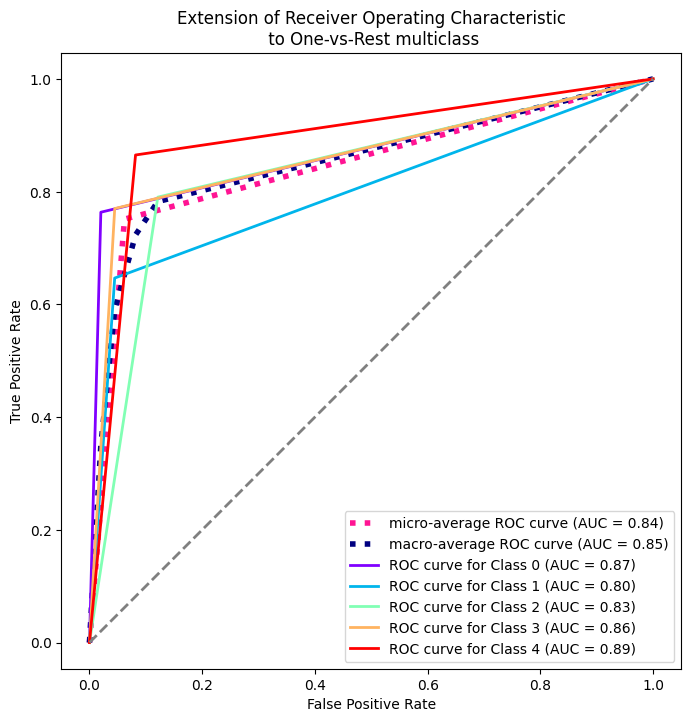

In [6]:
# def train_pytorch()
for seed in range(args.total_num_seed):
    print(f'SEED {seed}')
    print('--------------------------------')
    
    train_csv = os.path.join(args.data_path, 'train_embeddings.csv')
    val_csv = os.path.join(args.data_path, 'val_embeddings.csv')
    print(f"Train data: {train_csv}")
    print(f"Val data: {val_csv}")
    
    experiment_folder = f"{args.model}_{args.data_path.split('/')[-1]}"

    # Create output directories
    output_folder = os.path.join(os.getcwd(), args.output_dir, experiment_folder)
    seed_dir = os.path.join(output_folder, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    # Load datasets
    train_dataset = EmbeddingDataset(train_csv, shuffle=True)
    val_dataset = EmbeddingDataset(val_csv, shuffle=False)
    
    X_train, y_train = train_dataset.features, train_dataset.labels
    X_val, y_val = val_dataset.features, val_dataset.labels
    
    print(f"Embeddings shapes".center(60,"-"))
    print(f"Training: X: {X_train.shape} - y: {y_train.shape}\nValidation: X: {X_val.shape} - y: {y_val.shape}")

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    class_counts = np.bincount(np.asarray(y_train, int))
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    patience = 50  
    best_f1 = 0.0
    patience_counter = 0
    
    if args.model == 'svc':
        best_params = {'C': 10, 'gamma': "scale", 'kernel': 'rbf'}
        model = SVC(**best_params, probability=True, random_state=seed)
        
        start_train_time = time.time()
        model.fit(X_train, y_train)
        end_train_time = time.time()

        model_memory = get_memory_usage()

        start_inference_time = time.time()
        y_proba = model.predict_proba(X_val)
        y_pred = np.argmax(y_proba, axis=1)
        end_inference_time = time.time()

        training_time = end_train_time - start_train_time
        inference_time = end_inference_time - start_inference_time
        all_labels, all_preds = y_val, y_pred
        
    elif args.model == 'mlp':
        torch.manual_seed(seed)
        np.random.seed(seed)
        class_weights = class_weights.to(device)
        num_columns = X_train.shape[1]
        model = SClassifier(num_columns, args.num_classes, hidden_sizes=[256, 128, 64]).to(device)
        # model.apply(reset_weights)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
        scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.8)

        train_losses = []
        val_losses = []
        epoch_train_loss, epoch_val_loss = 0, 0

        start_train_time = time.time()
        
        for epoch in range(args.num_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device) 
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
            
            epoch_train_loss /= len(train_loader.dataset)
            train_losses.append(epoch_train_loss)
            
            model.eval()
            all_labels, all_preds = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device) 
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(predicted.cpu().numpy())
            
            epoch_val_loss /= len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

            f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            print(f'Epoch {epoch+1}/{args.num_epochs}, F1 Score: {f1}')
            scheduler.step(f1)
            
            if f1 > best_f1:
                best_f1 = f1
                patience_counter = 0
                torch.save(model.state_dict(), os.path.join(seed_dir, 'best_model.pth'))
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        end_train_time = time.time()
        model_memory = get_memory_usage()
        
        # Final evaluation
        start_inference_time = time.time()
        model.eval()
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) 
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        end_inference_time = time.time()

        training_time = end_train_time - start_train_time
        inference_time = end_inference_time - start_inference_time
        plot_losses(train_losses, val_losses, seed_dir)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_075 = fbeta_score(all_labels, all_preds, beta=0.75, average='weighted', zero_division=0)

    input_shape = (1, X_train.shape[1]) # bs 1 

    metrics = {
        'EMB_size_out': X_train.shape[1],
        'Accuracy': accuracy,
        'F1 Score': f1,
        'F0.75 Score': f1_075,
        'Precision': precision,
        'Recall': recall,
        'Training time': training_time,
        'Inference time': inference_time,
        'Memory RAM': model_memory}

    print(metrics)
    
    save_predictions(seed_dir, experiment_folder, model, metrics, all_labels, all_preds, seed)
    plot_multiclass_roc_curve(all_labels, all_preds, seed_dir)
    save_confusion_matrix(all_labels, all_preds, np.unique(y_train), seed_dir, "val")

consolidate_and_average_metrics(args, output_folder)
print("Evaluation across different seeds completed. Results saved to the output directory.")

# Calculate flops, macs, params

In [8]:
import torch
from calflops import calculate_flops
input_shape = (1, train_dataset.features.shape[1])  # Assuming X_train is defined and has the correct shape

dummy_input = torch.randn(input_shape).to(device)  # Random tensor with the appropriate shape

original_model = SClassifier(train_dataset.features.shape[1], args.num_classes, hidden_sizes=[256, 128, 64]).to(device)

# we load the best model
delete = "/home/sebastian/codes/repo_clean/VE_paper/1_Classification/results_jan_29/mlp_efficientnet_b3_1536_bs64/seed_0"
# model_path = os.path.join(seed_dir, "best_model.pth")
print(seed_dir)
model_path = os.path.join(delete, "best_model.pth")
original_model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True))

original_model.eval()

for param in original_model.parameters():
    param.requires_grad_(False)

# quantized_model = torch.quantization.quantize_dynamic(
#     original_model,
#     {torch.nn.Linear},
#     dtype=torch.qint8
# )

flops, macs, params = calculate_flops(model=original_model, 
                                      input_shape=input_shape,
                                      output_as_string=False,
                                      output_precision=4)
results = {'KFLOPS':flops/1e3,
            'KMACS':macs/1e3,
            'KPARAMS':params/1e3}
print(results)

/home/sebastian/codes/repo_clean/VE_paper/1_Classification/results_jan_29_test/mlp_efficientnet_b3_1536_bs64/seed_0

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  0       
fwd MACs:                                                               434.496 KMACs
fwd FLOPs:                                                              871.685 KFLOPS
fwd+bwd MACs:                                                           1.3035 MMACs
fwd+bwd FLOPs:                                                          2.6151 M